In [1]:
# now we create a quick function to calculate loss based on distance from centroid
def calc_loss(x,y,x_ref,y_ref):
    
    
    # calculate Euclidean distance btw person & centroid
    distance = np.sqrt((((x-x_ref)**2)+((y-y_ref)**2))) 
    
    # refer to the above distance function to determine individual loss
    loss = 1/(1+ np.exp(-1*distance)) #converts distances to probability distribution
    
    #return distance
    return loss

In [2]:
def calc_dist(x,y,x_ref,y_ref):
  return np.sqrt((((x-x_ref)**2)+((y-y_ref)**2))) 


In [3]:
# this function compares the loss between two groups at a certain percentile level
def compare_loss(group1,group2,percentile):
    select_group = [group1, group2]
    
    percentile_loss = []
    for s in select_group:
        s.sort_values(by=['min_loss'])
        subgroup = [s['min_loss']] # subset the two different groups of interest
        loss_p = stats.scoreatpercentile(subgroup, percentile) # find the level of loss at given percentile
        percentile_loss.append(loss_p) # load list with loss
        
    difference = percentile_loss[0]-percentile_loss[1] # find difference between two @ percentile
    
    return np.abs(difference)

In [4]:
#this function calculates the summation of all the individual losses within each cluster for minimizing the objective function
def sum_loss(cluster0, cluster1):
  cluster0_len = len(cluster0['min_loss'])
  cluster1_len = len(cluster1['min_loss'])
  tot = cluster0_len + cluster1_len
  #sums the losses from both clusters
  print(cluster0_len)
  print('c0 = ', cluster0['min_loss'].sum())
  tot_loss = (cluster0['min_loss'].sum() + cluster1['min_loss'].sum())/tot
  return tot_loss

In [5]:
#this function calculates the subgroup loss constraint for the objective function
def constraint(cluster0, cluster1, percentile):
  #calculation of subgroup loss between red and blue
  subgroup_loss_div = compare_loss(cluster0, cluster1,percentile)
  #based on the loss function defined, we divide the divergence of the 2 groups' loss by the number of subgroups
  subgroup_div_tot = subgroup_loss_div/2
  #want to dminimize this value
  return subgroup_div_tot




In [6]:
#calculates negative gradient for clusters
def update_weights(clust0, clust1, lr, centr, df):
  x_deriv_0, y_deriv_0 = 0, 0
  x_deriv_1, y_deriv_1 = 0, 0
  #total number of points in cluster 0 (points nearest to centroid 0)
  N_0 = len(clust0['x_coord'])
  #total number of points in cluster 1 (points nearest to centroid 1)
  N_1 = len(clust1['x_coord'])
  #updated centroid coordinates 
  new_centr_x0, new_centr_y0 = centr[0][0], centr[0][1]
  new_centr_x1, new_centr_y1 = centr[1][0], centr[1][1]

  #gets new assignments for clusters based on euclidean distance



  for i in range(N_0):
    #calculate partial derivatives
    #(e^-d/(1+e^-d)^2)

    x = clust0['x_coord'][i]
    y = clust0['y_coord'][i]

    distance = clust0['dist_from_0'][i]

    numerator_x = centr[0][0]-x
    denominator_x = distance
    grad_x = (numerator_x/denominator_x)

    numerator_y = centr[0][1]-y
    denominator_y = distance
    grad_y = (numerator_y/denominator_y)

    x_deriv_0 += grad_x
    y_deriv_0 += grad_y
  
  loss_grad_x = x_deriv_0/float(N_0)
  loss_grad_y = y_deriv_0/float(N_0)


  new_centr_x0 -= (loss_grad_x) * lr
  new_centr_y0 -= (loss_grad_y) * lr



  for i in range(N_1):

    #calculate partial derivatives
    #(e^-d/(1+e^-d)^2)
    x = clust1['x_coord'][i]
    y = clust1['y_coord'][i]

    distance = clust1['dist_from_1'][i]

    numerator_x = centr[1][0]-x
    denominator_x = distance
    grad_x = (numerator_x/denominator_x)

    numerator_y = centr[1][1]-y
    denominator_y = distance
    grad_y = (numerator_y/denominator_y)

    x_deriv_1 += grad_x
    y_deriv_1 += grad_y
  
  loss_grad_x = x_deriv_1/float(N_1)
  loss_grad_y = y_deriv_1/float(N_1)


  new_centr_x1 -= (loss_grad_x) * lr
  new_centr_y1 -= (loss_grad_y) * lr

  return (new_centr_x0, new_centr_y0), (new_centr_x1, new_centr_y1)





In [7]:
_#updates centroid locations based on gradient descent and loss constraint
def update(clust0, clust1, lr, centroids,loss, df):
  # all points in group 0 (blue points)
  group_0 = df[df['group']==0]
  group_0 = group_0.reset_index()

  #all points in group 1 (red points)
  group_1 = df[df['group']==1]
  group_1 = group_1.reset_index()

  sorted_data_0 = group_0.sort_values(by=['min_loss'])
  sorted_len_0 = len(sorted_data_0['min_loss'])
  yvals_0 = np.arange(sorted_len_0)/float(sorted_len_0-1)

  sorted_data_1 = group_1.sort_values(by=['min_loss'])
  sorted_len_1 = len(sorted_data_1['min_loss'])
  yvals_1 = np.arange(sorted_len_1)/float(sorted_len_1-1)


  #subgroup loss between red and blue points
  subgroup_loss = compare_loss(sorted_data_0, sorted_data_1, 50)

  #total subgroup loss to be used for evaluation with constraint
  subgroup_loss = subgroup_loss/2

  L = .01
  while subgroup_loss > L:
    print('subgroup loss: ', subgroup_loss)


    old_loss = loss
    temp_centroids = {0:(0,0),
                      1:(0,0)}
    temp = update_weights(clust0, clust1, lr, centroids, df)

    #testing to see if new centroid locations improve summation of individual loss
    temp_centroids[0] = temp[0]
    temp_centroids[1] = temp[1]

    df = assign_cluster(df, temp_centroids)
    #all points clustered around centroid 0
    clust0 = df[df['min_centr'] == 0]
    clust0 = clust_0.reset_index()
    #all points clustered around centroid 1
    clust1 = df[df['min_centr'] == 1]
    clust1 = clust_1.reset_index()
    group_0 = df[df['group']==0]
    group_0 = group_0.reset_index()

    #all points in group 1 (red points)
    group_1 = df[df['group']==1]
    group_1 = group_1.reset_index()

    sorted_data_0 = group_0.sort_values(by=['min_loss'])

    sorted_data_1 = group_1.sort_values(by=['min_loss'])


    loss = sum_loss(clust0, clust1)
    subgroup_loss = compare_loss(sorted_data_0, sorted_data_1, 50)

    #total subgroup loss to be used for evaluation with constraint
    subgroup_loss = subgroup_loss/2
    print('old loss: ', old_loss)
    print('new loss: ', loss)
    print('subgroup loss: ', subgroup_loss)



    if loss >= old_loss or subgroup_loss > L:
      centroids[0] = temp[0]
      centroids[1] = temp[1]
      print('centroids ', centroids)
    else:
      return centroids




In [8]:
def assign_cluster(df, centroids):
  for i in centroids.keys():
    #loss based on euclidean distance for each individual point compared to both centroids
    #stored in dataframe
    df['loss_from_{}'.format(i)] = calc_loss(df['x_coord'], df['y_coord'], centroids[i][0], centroids[i][1])
    df['dist_from_{}'.format(i)] = calc_dist(df['x_coord'], df['y_coord'], centroids[i][0], centroids[i][1])

  centroid_dist_col = ['loss_from_{}'.format(i) for i in centroids.keys()]

  #df column which holds the value of the closest centroid for each point
  df['min_centr'] = df.loc[:, centroid_dist_col].idxmin(axis=1)
  df['min_centr'] = df['min_centr'].map(lambda x: int(x.lstrip('loss_from_')))
  
  #value of loss calculated from sigmoid in calc_loss function for individual loss
  df['min_loss'] = df[['loss_from_0','loss_from_1']].min(axis=1)
  #color of the closest centroid to each point
  df['color'] = df['min_centr'].map(lambda x: color_map[x])
  return df




/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


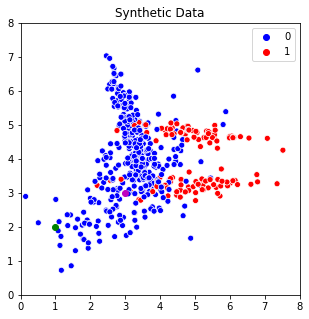

In [9]:
from sklearn.datasets import make_classification
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from scipy import stats


# Generate Imbalanced Synthetic Data
X,y = make_classification(n_samples=500, shift=4 ,n_features=2,n_informative=2, n_redundant=0, n_repeated=0, n_classes=2, n_clusters_per_class=2,class_sep=.8,flip_y=0,weights=[0.75,0.25], random_state=55)

#create dataframe to hold x and y coordinates
df = pd.DataFrame({
    'x_coord': X[:,0],
    'y_coord': X[:,1]
})

#red vs blue points
#if group = 0, then the point is in the blue group
# if group = 1, then the point is in the red group
df['group'] = y


# np.random.seed(42)

#arbitrarily picked random k (number of centroids)
k = 2

#randomly initialized centroid x and y coordinates (in real data we will actually have these coordinates)
centroids = {
    0: (1,2),
    1: (3, 3)
}

#colors for centroids
color_map = {0: 'g', 1: 'm'}


#plot synthetic data
fig = plt.figure(figsize=(5,5))
ax = sns.scatterplot(X[:,0],X[:,1],hue=y, palette=['blue','red'])

for i in centroids.keys():
  plt.scatter(centroids[i][0], centroids[i][1], color=color_map[i])
df = assign_cluster(df, centroids)
df
plt.xlim(0, 8)
plt.ylim(0, 8)
ax.set_title("Synthetic Data");
plt.show()



In [10]:
df = assign_cluster(df, centroids)
df

,x_coord,y_coord,group,loss_from_0,dist_from_0,loss_from_1,dist_from_1,min_centr,min_loss,color
0,3.126701,5.861518,0,0.987972,4.408422,0.946054,2.864322,1,0.946054,m
1,3.009882,3.865715,0,0.939480,2.742356,0.703865,0.865771,1,0.703865,m
2,1.910421,2.200962,0,0.717549,0.932337,0.794320,1.351164,0,0.717549,g
3,3.884626,4.533612,1,0.978944,3.839304,0.854515,1.770460,1,0.854515,m
4,3.779372,2.588979,0,0.944856,2.841092,0.707053,0.881112,1,0.707053,m
...,...,...,...,...,...,...,...,...,...,...
495,3.672692,4.300994,0,0.971439,3.526735,0.812238,1.464616,1,0.812238,m
496,4.252466,3.995263,0,0.978452,3.815706,0.831984,1.599756,1,0.831984,m
497,4.827376,4.849431,1,0.991604,4.771589,0.930858,2.599942,1,0.930858,m
498,3.590866,3.208162,0,0.945767,2.858714,0.651687,0.626462,1,0.651687,m


In [11]:
#all points clustered around centroid 0
clust_0 = df[df['min_centr'] == 0]
clust_0 = clust_0.reset_index()


#all points clustered around centroid 1
clust_1 = df[df['min_centr'] == 1]
clust_1 = clust_1.reset_index()

#all points in group 0 (blue points)
group_0 = df[df['group']==0]
group_0 = group_0.reset_index()

#all points in group 1 (red points)
group_1 = df[df['group']==1]
group_1 = group_1.reset_index()

#blue = 0
#red = 1

#dictionary storing total red and blue points associated with centrioid 0
clust_0_groups = {0: clust_0.loc[clust_0['group']==0, 'group'].count(), 
                  1: clust_0.loc[clust_0['group']==1, 'group'].count()}

#total number of points in cluster around centroid 0
clust0_tot = clust_0_groups[0] + clust_0_groups[1]

#dictionary storing total red and blue points associated with centrioid 1
clust_1_groups = {0: clust_1.loc[clust_1['group']==0, 'group'].count(), 
                  1: clust_1.loc[clust_1['group']==1, 'group'].count()}

#total number of points in cluster around centroid 1
clust1_tot = clust_1_groups[0] + clust_1_groups[1]


In [12]:
#Total Percentages of Red and Blue in population 
red_percent = (clust_0_groups[1] + clust_1_groups[1])/(clust0_tot + clust1_tot)
blue_percent = (clust_0_groups[0] + clust_1_groups[0])/(clust0_tot + clust1_tot)

print('red: ', red_percent)
print('blue: ', blue_percent)

red:  0.25
blue:  0.75


In [13]:
#Total Percentages Per Cluster
#Cluster 0 red percentage
clust0_percent_red = clust_0_groups[1]/clust0_tot

#Cluster 0 blue percentage
clust0_percent_blue = clust_0_groups[0]/clust0_tot

print("Cluster 0: ")
print('red: ', clust0_percent_red)
print('blue: ', clust0_percent_blue)

#Cluster 1 red percentage
clust1_percent_red = clust_1_groups[1]/clust1_tot

#Cluster 0 blue percentage
clust1_percent_blue = clust_1_groups[0]/clust1_tot

print("Cluster 1: ")
print('red: ', clust1_percent_red)
print('blue: ', clust1_percent_blue)


#new dataframe for the percentages of each group in both clusters and the total population
color_rates = pd.DataFrame({'color': ['red', 'blue'],
                            'population_level': [red_percent, blue_percent],
                            'cluster_0': [clust0_percent_red, clust0_percent_blue],
                            'cluster_1': [clust1_percent_red, clust1_percent_blue]})
color_rates

Cluster 0: 
red:  0.0
blue:  1.0
Cluster 1: 
red:  0.26595744680851063
blue:  0.7340425531914894


,color,population_level,cluster_0,cluster_1
0,red,0.25,0.0,0.265957
1,blue,0.75,1.0,0.734043


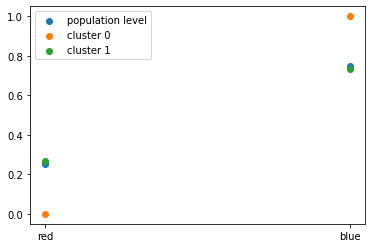

In [14]:
#plot representing the percentage differences in red/blue group representation on population/cluster level
plt.scatter(color_rates['color'], color_rates['population_level'],label='population level')
plt.scatter(color_rates['color'],color_rates['cluster_0'],label = 'cluster 0')
plt.scatter(color_rates['color'],color_rates['cluster_1'],label = 'cluster 1')
plt.legend()

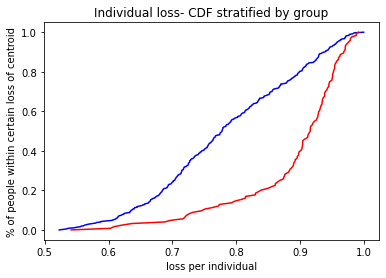

0.7774471737827079
0.915570256445792
-0.13812308266308415


In [15]:
#CDF for all blue and red points
#cdf for group 0 (all blue points)
sorted_data_0 = group_0.sort_values(by=['min_loss'])
sorted_len_0 = len(sorted_data_0['min_loss'])
yvals_0 = np.arange(sorted_len_0)/float(sorted_len_0-1)

#cdf for group 1 (all red points)
sorted_data_1 = group_1.sort_values(by=['min_loss'])
sorted_len_1 = len(sorted_data_1['min_loss'])
yvals_1 = np.arange(sorted_len_1)/float(sorted_len_1-1)


plt.plot(sorted_data_0['min_loss'], yvals_0, 'b')
plt.plot(sorted_data_1['min_loss'], yvals_1, 'r')

plt.xlabel('loss per individual')
plt.ylabel('% of people within certain loss of centroid')
plt.title('Individual loss- CDF stratified by group')
plt.show()

x = stats.scoreatpercentile(sorted_data_0['min_loss'], 50)
r = stats.scoreatpercentile(sorted_data_1['min_loss'], 50)
print(x)
print(r)
print(x-r)
#blue = 0 (blue points)
#red = 1 (red points)

In [16]:
df = assign_cluster(df, centroids)
df
loss = sum_loss(clust_0, clust_1)
loss
update(clust_0, clust_1, .01, centroids,loss,df )

30
c0 =  20.694626611926388
subgroup loss:  0.06906154133154208
30
c0 =  20.694626611926388
old loss:  0.8091200828890013
new loss:  0.8091200828890013
subgroup loss:  0.0691758111795488
centroids  {0: (1.00666461552394, 1.9992593682827513), 1: (3.0037283212698487, 3.005626059008493)}
subgroup loss:  0.0691758111795488
30
c0 =  20.694626611926388
old loss:  0.8091200828890013
new loss:  0.8091200828890013
subgroup loss:  0.06923767331311753
centroids  {0: (1.0132186225746616, 1.9985310283688584), 1: (3.0074237306147364, 3.01120245372614)}
subgroup loss:  0.06923767331311753
30
c0 =  20.694626611926388
old loss:  0.8091200828890013
new loss:  0.8091200828890013
subgroup loss:  0.06933958888742658
centroids  {0: (1.019663856852109, 1.9978147762589162), 1: (3.0110865185661724, 3.0167296225667193)}
subgroup loss:  0.06933958888742658
30
c0 =  20.694626611926388
old loss:  0.8091200828890013
new loss:  0.8091200828890013
subgroup loss:  0.06963965192422522
centroids  {0: (1.0260021235902583

KeyboardInterrupt: ignored

In [ ]:
centroids 